In this notebook we will apply Strategy 2 for transfer learning. When using this strategy we train some layers while leaving other layers frozen.

This technique is indicated in two cases:

1. **Large dataset and similar to the pre-trained model dataset:** Since the dataset is large  overfitting shouldn’t be an issue, so we can learn as much as we want. However, since the datasets are similar, we can save ourselves from a huge training effort by leveraging previous knowledge. Therefore, it should be enough to train the classifier and the top layers of the convolutional base.

2. **Small dataset and similar to the pre-trained model dataset:** In this case is a challenge to find a balance between the number of layers to train and freeze.  This because on one side, if you go to deep you risk overfitting while on the other side, if not the model will not learn enough. Data augmentation is a technique that should be considered in order to fight overfitting and allow the model to learn enough.

This method is known as `Fine-tuning`. `Fine-tuning` is widely used technique for model reuse and complementary to feature extraction. 

Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (the classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In addition, because our dataset is small we will make use of data augmentation.

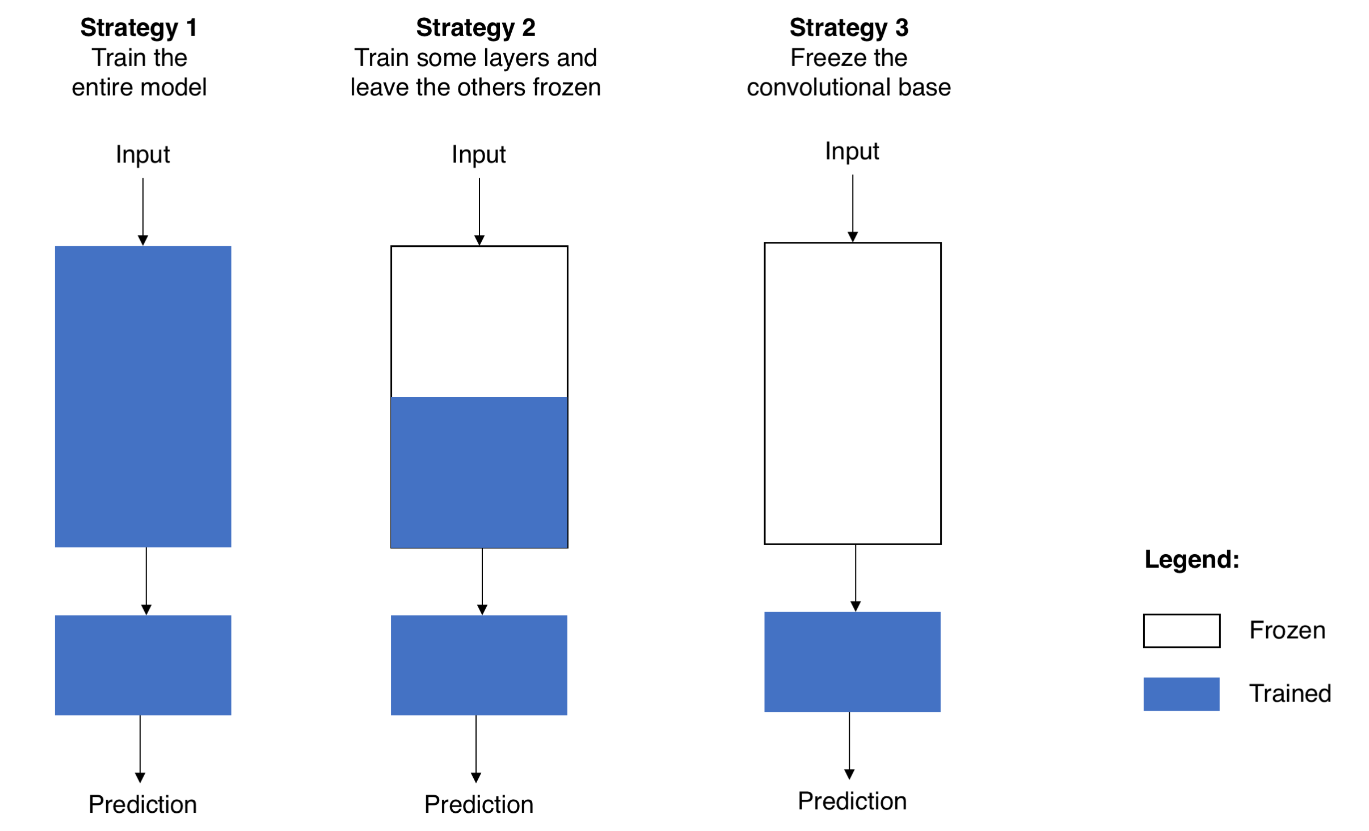

In [1]:
from IPython.display import Image
Image("strategies.png")

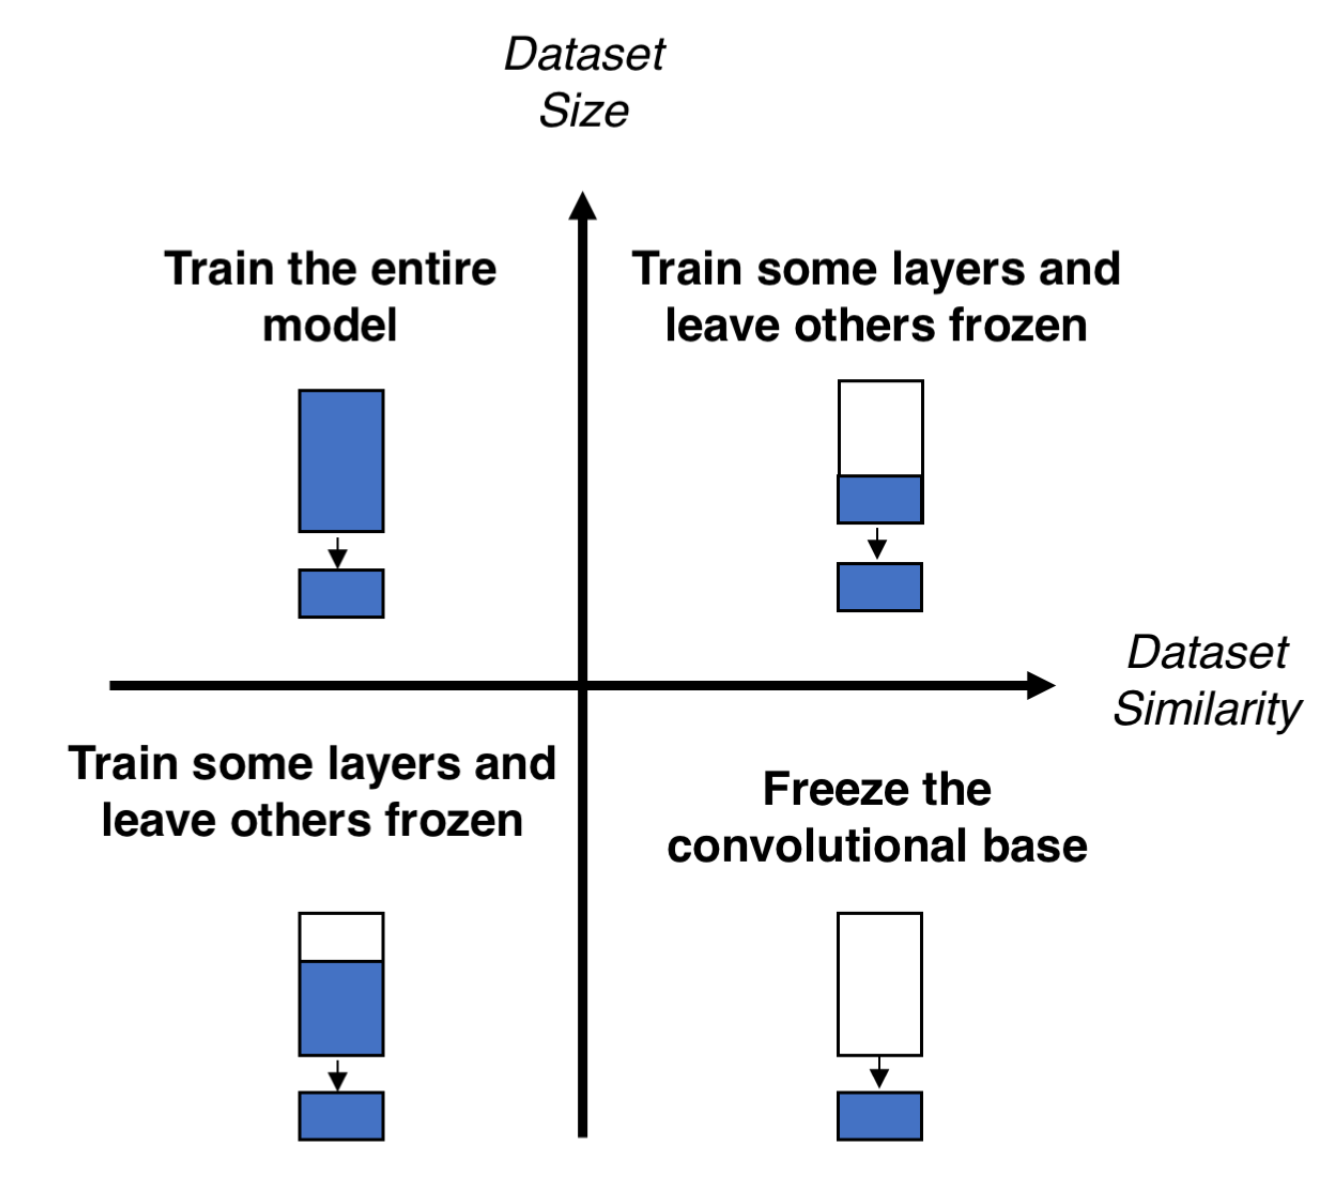

In [2]:
from IPython.display import Image
Image("approaches.png")

It is necessary to freeze the convolution base of the pre-trained network in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already be trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

**Step1** Add your custom network on top of an already trained base network.

**Step2** Freeze the base network.

**Step3** Train the part you added (Classifier).

**Step4** Unfreeze some layers in the base network.

**Step5** Jointly train both these layers and the part you added.

# The Convolutional Base (conv_base)

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for InceptionV3 is 299,299

In [4]:
# Instantiate convolutional base

from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        input_shape=(img_width, img_height, img_channels), 
                        pooling=None)

Using TensorFlow backend.


In [5]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [6]:
conv_base.input_shape

(None, 128, 128, 3)

# Data preparation - Data augmentation

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All imgs will be resized to img_height x img_width
        target_size=(img_height, img_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


# Fully Connected Layers (FCL) classifier

## Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [8]:
# Define model

from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 23,900,449
Trainable params: 23,866,017
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 inception_v3 False
1 flatten_1 True
2 dense_1 True
3 dropout_1 True
4 dense_2 True


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with data augmentation.

## Compile model

In [13]:
import pandas as pd

def info_layers(conv_base,model):
    
    list_layer_name = []
    list_trainable = []

    for layer in conv_base.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    

    df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    list_layer_name = []
    list_trainable = []

    for layer in model.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    
    df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    df2 = df2[1:]

    df= pd.concat([df1,df2])
    df.reset_index(drop=True,inplace=True)
    
    pd.options.display.max_rows = len(df)
    
    return df

In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d_1 True
2 batch_normalization_1 True
3 activation_1 True
4 conv2d_2 True
5 batch_normalization_2 True
6 activation_2 True
7 conv2d_3 True
8 batch_normalization_3 True
9 activation_3 True
10 max_pooling2d_1 True
11 conv2d_4 True
12 batch_normalization_4 True
13 activation_4 True
14 conv2d_5 True
15 batch_normalization_5 True
16 activation_5 True
17 max_pooling2d_2 True
18 conv2d_9 True
19 batch_normalization_9 True
20 activation_9 True
21 conv2d_7 True
22 conv2d_10 True
23 batch_normalization_7 True
24 batch_normalization_10 True
25 activation_7 True
26 activation_10 True
27 average_pooling2d_1 True
28 conv2d_6 True
29 conv2d_8 True
30 conv2d_11 True
31 conv2d_12 True
32 batch_normalization_6 True
33 batch_normalization_8 True
34 batch_normalization_11 True
35 batch_normalization_12 True
36 activation_6 True
37 activation_8 True
38 activation_11 True
39 activation_12 True
40 mixed0 True
41 conv2d_16 True
42 batch_normalization_16 True
43 activation_16 True
44 con

In [15]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,conv2d_1,True
2,batch_normalization_1,True
3,activation_1,True
4,conv2d_2,True
5,batch_normalization_2,True
6,activation_2,True
7,conv2d_3,True
8,batch_normalization_3,True
9,activation_3,True


In [16]:
conv_base.trainable = True

for layer in conv_base.layers[:249]:
    layer.trainable = False

In [17]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,conv2d_1,False
2,batch_normalization_1,False
3,activation_1,False
4,conv2d_2,False
5,batch_normalization_2,False
6,activation_2,False
7,conv2d_3,False
8,batch_normalization_3,False
9,activation_3,False


In [18]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [19]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-28 07:11:53.904078


In [20]:
# Train model

# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 250s 2s/step - loss: 0.6371 - acc: 0.7190 - val_loss: 0.4045 - val_acc: 0.7560
Epoch 2/30
100/100 [==============================] - 226s 2s/step - loss: 0.5944 - acc: 0.7480 - val_loss: 0.6327 - val_acc: 0.7683
Epoch 3/30
100/100 [==============================] - 194s 2s/step - loss: 0.6256 - acc: 0.7108 - val_loss: 0.5020 - val_acc: 0.7560
Epoch 4/30
100/100 [==============================] - 195s 2s/step - loss: 0.5883 - acc: 0.7309 - val_loss: 0.5163 - val_acc: 0.7734


## Save model

In [21]:
model.save("../models/InceptionV3_firebreak_detection_fine_tuning_FC_model.h5")

## Model evaluation

### Learning curves

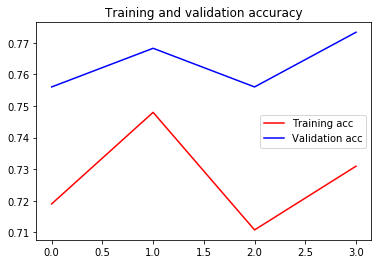

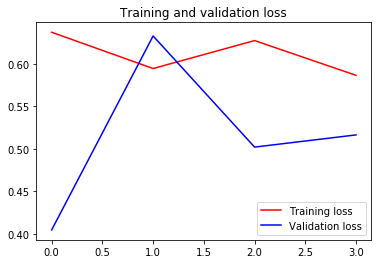

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/InceptionV3_firebreak_detection_fine_tuning_FC_history.csv", index = False)

In [24]:
t2 = datetime.datetime.now()
print(t2)
print(t2-t1)

2019-11-28 07:26:42.687093
0:14:48.783015


### Model in action

In [25]:
def prediction_dataframe(generator):
    """ Generate dataframe with filename, probability, and class of the image
    """
    

    # Predict from generator (returns probabilities)
    pred=model.predict_generator(generator, steps=len(generator), verbose=1)

    # Get classes by np.round
    cl = np.round(pred)
    # Get filenames (set shuffle=false in generator is important)
    filenames=generator.filenames

    # Data frame
    results=pd.DataFrame({"file_name":filenames,"prob":pred[:,0], "class":cl[:,0]})
    results['file_name'] = results['file_name'].apply(lambda x: x.split('\\')[-1])
    
    return results

In [26]:
# obtaining predictions for test images

results = prediction_dataframe(test_generator)
results.head()

32/32 [==============================] - 33s 1s/step


,file_name,prob,class
0,2017-12-12 11-56-38_NAO.jpeg,0.084760,0.0
1,2018-01-09 16-17-15_NAO.jpeg,0.140152,0.0
2,2018-01-09 17-10-54_NAO.jpeg,0.133816,0.0
3,2018-01-30 08-53-00_NAO.jpeg,0.251778,0.0
4,2018-01-30 09-07-13_NAO.jpeg,0.246065,0.0


In [27]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases, results):
    """ shows images and prediction considering threshold of 0.5 and test images"""
    
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Make prediction
        
        idx = results.index[results['file_name'] == random_img].tolist()
        prediction = results['prob'].loc[idx[0]]

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

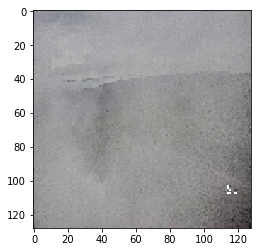

2018-02-24 08-33-43_SIM.jpeg
Not firebreack


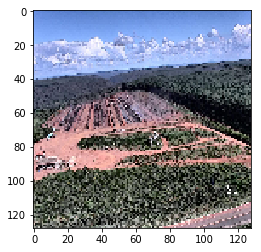

2018-03-19 15-41-27_SIM.jpeg
Not firebreack


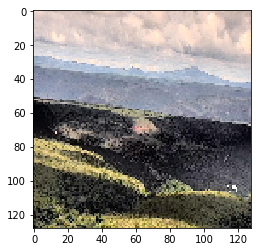

2018-03-14 10-29-42_NAO.jpeg
Not firebreack


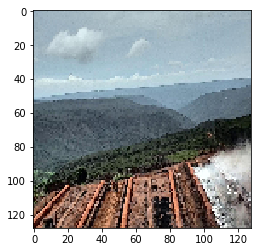

2018-03-08 10-07-32_NAO.jpeg
Not firebreack


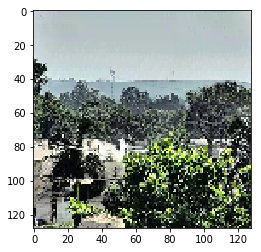

2018-01-31 10-03-12_SIM.jpeg
Not firebreack


In [28]:
# Visualize predictions
visualize_predictions(model, 5, results)

# Global average pooling

## Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [30]:
# Instantiate convolutional base

from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(include_top=False, 
                        weights='imagenet', 
                        input_tensor=None, 
                        input_shape=(img_width, img_height, img_channels), 
                        pooling=None)

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 63, 63, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 63, 63, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [31]:
# Define model

from keras import models
from keras import layers

#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [32]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190


In [33]:
conv_base.trainable = False

In [34]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [35]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 inception_v3
1 global_average_pooling2d_1
2 dense_3


## Compile model

In [36]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv2d_95 True
2 batch_normalization_95 True
3 activation_95 True
4 conv2d_96 True
5 batch_normalization_96 True
6 activation_96 True
7 conv2d_97 True
8 batch_normalization_97 True
9 activation_97 True
10 max_pooling2d_5 True
11 conv2d_98 True
12 batch_normalization_98 True
13 activation_98 True
14 conv2d_99 True
15 batch_normalization_99 True
16 activation_99 True
17 max_pooling2d_6 True
18 conv2d_103 True
19 batch_normalization_103 True
20 activation_103 True
21 conv2d_101 True
22 conv2d_104 True
23 batch_normalization_101 True
24 batch_normalization_104 True
25 activation_101 True
26 activation_104 True
27 average_pooling2d_10 True
28 conv2d_100 True
29 conv2d_102 True
30 conv2d_105 True
31 conv2d_106 True
32 batch_normalization_100 True
33 batch_normalization_102 True
34 batch_normalization_105 True
35 batch_normalization_106 True
36 activation_100 True
37 activation_102 True
38 activation_105 True
39 activation_106 True
40 mixed0 True
41 conv2d_110 True
42 batch_

In [37]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,conv2d_95,True
2,batch_normalization_95,True
3,activation_95,True
4,conv2d_96,True
5,batch_normalization_96,True
6,activation_96,True
7,conv2d_97,True
8,batch_normalization_97,True
9,activation_97,True


In [38]:
conv_base.trainable = True

for layer in conv_base.layers[:249]:
    layer.trainable = False

In [39]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,conv2d_95,False
2,batch_normalization_95,False
3,activation_95,False
4,conv2d_96,False
5,batch_normalization_96,False
6,activation_96,False
7,conv2d_97,False
8,batch_normalization_97,False
9,activation_97,False


In [40]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [41]:
# Train model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 234s 2s/step - loss: 0.5854 - acc: 0.7345 - val_loss: 0.5128 - val_acc: 0.7288
Epoch 2/30
100/100 [==============================] - 217s 2s/step - loss: 0.5788 - acc: 0.7500 - val_loss: 0.4880 - val_acc: 0.7205
Epoch 3/30
100/100 [==============================] - 226s 2s/step - loss: 0.5485 - acc: 0.7491 - val_loss: 0.5007 - val_acc: 0.7611
Epoch 4/30
100/100 [==============================] - 253s 3s/step - loss: 0.5686 - acc: 0.7505 - val_loss: 0.5775 - val_acc: 0.7551
Epoch 5/30
100/100 [==============================] - 220s 2s/step - loss: 0.5394 - acc: 0.7595 - val_loss: 0.5652 - val_acc: 0.7601


## Save model

In [42]:
model.save("../models/InceptionV3_firebreak_detection_fine_tuning_GAP_model.h5")

# Model evaluation

## Learning curves

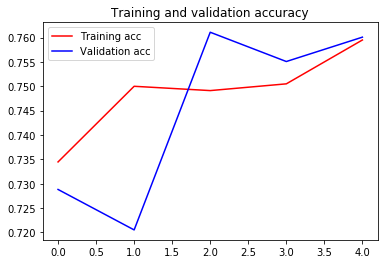

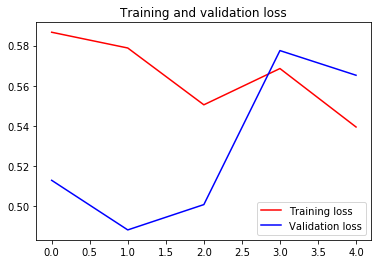

In [43]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/InceptionV3_firebreak_detection_fine_tuning_GAP_history.csv", index = False)

In [45]:
t3 = datetime.datetime.now()
print(t3)
print(t3-t2)

2019-11-28 08:00:25.005970
0:33:42.318877


## Model in action

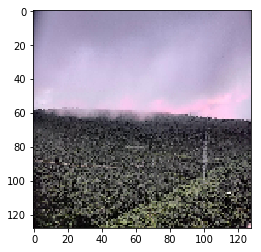

2018-03-18 05-57-44_SIM.jpeg
Not firebreack


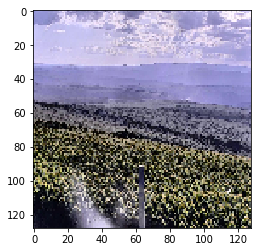

2018-03-20 16-36-42_NAO.jpeg
Not firebreack


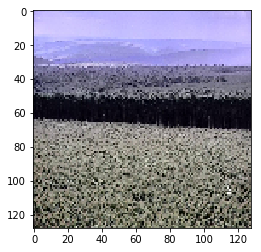

2018-03-04 13-21-17_NAO.jpeg
Not firebreack


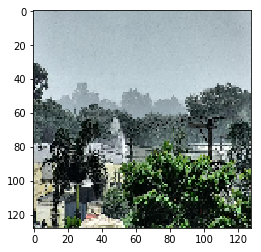

2018-01-30 15-54-02_SIM.jpeg
Not firebreack


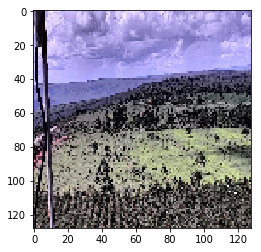

2018-03-12 14-03-09_NAO.jpeg
Not firebreack


In [46]:
# Visualize predictions
visualize_predictions(model, 5, results)

**REFERENCES**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks